# Build a new transient


By inherating ``Transient`` you can define any new transient you want. 

You should provide:
  - **rate**: you must provide a rate as ``_RATE: `float` or `func` ``:
      - If ``_RATE`` is a float, it is assumed to be the volumetric rate (transient/Gpc$^3$/year)
      - If ``_RATE`` is a function, it must have ``@staticmethod`` decorator **and** have ``z`` as first parameter. This function will be used as ``self.get_rate(z, **kwargs)``
  
  
  - **model**: you must provide the model, that is, how the transient parameters are draw ``_MODEL: `dict` ``. Model building is detailed below.
  
  
  - **template**: you *could* provide the template that handel how the transient lightcurve are generated. This is required if you want to built a dataset out of the transient you created.  To do that you must provide ``_TEMPLATE``. The format there is very flexible. All will be converted in `skysurvey.Template`. The following are accepted.
      - a `string` (name of a sncosmo.Source), 
      - a `sncosmo.Source`, 
      - a `sncosmo.Model`,
      - a `skysruvey.Template`
      
      
**If you provide these three keyword: ``_RATE``, ``_TEMPLATE`` and ``_MODEL``. You will have a functioning ``Transient``.**

## Build a minimal TimeSerieTransient

**Let's build the minimal transient corresponding to the "v19-2013df" model** (Type IIb) from sncosmo (see list [here](https://sncosmo.readthedocs.io/en/stable/source-list.html))

- ``_TEMPLATE`` will simply be "v19-2013df"

For the rate, let's say it's volumetric rate is 1e3 (for a comparison, SNeIa are 2e4)
- ``_RATE`` will simply be 1e3

Let's build the model now.

### Building the model

let's first check what are the free parameters of 'v19-2013df'

In [10]:
import sncosmo
sncosmo_mode = sncosmo.Model(source="v19-2013df")
sncosmo_mode.param_names

['z', 't0', 'amplitude']

- **z**: the redshift
- **t0**: the explosion date
- **amplitude**: the amplitude (corresponds to x0 in salt2, this is connected to the peak magnitude, but in flux)

the model will build must thus have at least these three parameters

(see details on how complex models can be built in the the "Build a new model" tutorials)

#### - Redshift (z)

redshifts are drawn following the ``getpdf_redshift()`` methods of `Transient` that basically derives `get_rate()` per bin of redshifts ($\Delta_z=10^{-3}$ by default). You can specify the maximum redshift you want "zmax".

For the model it means (specify ``as:"z"``) since sncosmo calls redshift ("z") in the model:

- ``redshift = {"param":{"zmax=0.1"}, as:"z"}`` 

No need to specify a "model" for redshift as "*redshift*" is a special key-word using the rate function.

#### - explosion time (t0)

Let's imagine you want a uniform probability between ``mjd=56000`` and ``mjd=57000``. Simply do:

- ``t0 = {"model":np.random.uniform, "param":{"low":56000, "high":57000}}``

#### - amplitude (based on magabs)

You could simply use the same kind of modeling as "t0", but this will be unrealist. Let's make a consistent model for which the amplitude is connected to the absolute magnitude of the target and it's redshift.

Let's say your transient as an absolute magnitude of $-18 \pm 1$. 
Then, it should goes as follow: (1) draw a ``magabs`` (2) convert it into a ``magobs`` given the target redshift and (2) finally converts this ``magobs`` into an ``amplitude``. 

You have built-in methods of Transient that can do that: 
- ``Transient.magabs_to_magobs(z, magabs, **kwargs)``
- ``Transient.magobs_to_amplitude(magobs, **kwargs)``

So the modeling of an consistent amplitude drawing needs 3 step

- ``magabs = {"model": np.random.norm, "param":{"loc":-18, "scale":1}}``
- ``magobs = {"model": "magabs_to_magobs", input=["magabs","z"]}``
- ``amplitude = {"model": "magobs_to_amplitude", input=["magobs"]}``

#### Sky coordinates (needed when connected to a transient)

Simply add:

- ``radec={"model":"random", "as":["ra","dec"]}``

To get a random 2d sky distribution

So all together, building from scratch a new transient goes as follows:

In [13]:
class MyTransient( Transient ):
        
    _TEMPLATE = "v19-2013df"
    _RATE = 1e3 # volumetric rate in Gpc^3/year
    
    _MODEL = dict( redshift = {"param":{"zmax":0.05}, "as":"z"}, # the 'z' parameters
                   t0 = {"model":np.random.uniform, "param":{"low":56000, "high":57000}}, # the 't0' parameters
                  # building the 'amplitude' parameter connected to the magabs
                   magabs = {"model": np.random.normal,
                             "param":{"loc":-18, "scale":1}},
                   magobs = {"model": "magabs_to_magobs",
                             "input":["z", "magabs"]},
                   amplitude = {"model":"magobs_to_amplitude",
                                "input":["magobs"]},
                  
                   # and get the spatial distribution
                   radec={"model":"random", "as":["ra","dec"]}
                 )

In [14]:
mytransient = MyTransient.from_draw(4000)
mytransient.data

,z,t0,magabs,magobs,amplitude,ra,dec
0,0.0345,56200.881737,-18.444654,17.532867,3.763530e-14,52.529492,-35.218668
1,0.0345,56578.467944,-18.364870,17.612651,3.496889e-14,353.266203,-2.908036
2,0.0445,56631.548601,-17.812113,18.733812,1.245138e-14,331.617426,-62.885760
3,0.0365,56979.871295,-16.013951,20.089097,3.573578e-15,336.427629,16.655036
4,0.0345,56783.707626,-17.609751,18.367769,1.744354e-14,44.595900,49.011505
...,...,...,...,...,...,...,...
3995,0.0235,56747.417561,-18.830523,16.295702,1.176146e-13,285.707185,-53.010184
3996,0.0445,56264.158420,-17.926827,18.619097,1.383895e-14,334.322685,-26.192990
3997,0.0455,56322.439205,-16.710013,19.885726,4.309744e-15,173.214148,-22.858094
3998,0.0165,56748.739902,-18.802529,15.544466,2.349392e-13,118.498934,4.447301


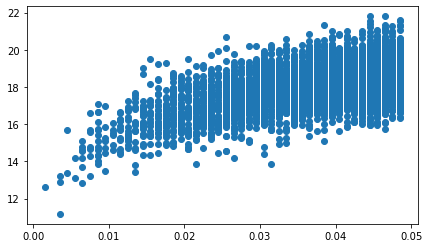

In [17]:
_ = mytransient.show_scatter("z","magobs")

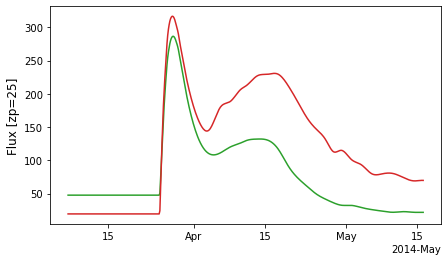

In [18]:
_ = mytransient.show_lightcurve(["ztfg","ztfr"], index=90)

In [ ]:
## Start with an example

In [1]:
from skysurvey.target import Transient

## Build a minimal TimeSerieTransient

This example below is typically what you want to do.

Assuming you template is `sncosmo.Source`

In [2]:
import numpy as np
import sncosmo

class NewTransient( Transient ):
    _KIND = "SNnew" # not mandatory.
    _TEMPLATE = sncosmo.Source # sncosmo model or source
    _RATE = 1 * 10**3 # volumetric rate of the transient

    _MODEL = dict( # Draw variable from a very simple method (only needs size as param).
                   magabs = {"model":"my_defined_method"},

                   # draw_redshift is defined for Transients
                   redshift = {"param":{"zmax":0.2},  "as":"z"}, # you can change the stored variable name.

                   # use a func drawing variables directly (e.g. numpy.random. )
                   noise = {"model": np.random.normal, 
                            "param":{"loc":0, "scale":0.5}},

                   # use one of the few pre-defined method e.g., magabs_to_magobs 
                    magobs = {"model": "magabs_to_magobs", 
                                "input":["z","magabs"]}, # "magabs_to_magobs has 2 mandatory inputs"

                    bias = {"model":np.random.uniform, 
                            "param":{"low":-1, "high":+1}},

                    # Create a complexe method that needs input.
                    magobs_eff = {"model": "my_method_needs_input", 
                                    "input":["magobs","bias"]},# "my_method_needs_input has 2 mandatory inputs"
                 )

    def my_defined_method(self, size=None, boundaries=[-14,-18]):
        """ """
        return np.random.uniform(*boundaries, size=size)

    # remark here, no size, it will be that of p1 and noise
    def my_method_needs_input(self, magobs, bias):
        """ returns ``scale*(a*coef + noise)``"""
        return magobs+bias

all methods from Transients, such as the ``from_draw()`` class method or the ``show_scatter()`` are then passed to ``NewTransient``

In [3]:
newtarget = NewTransient.from_draw(5000) # all method
newtarget.data

,magabs,z,noise,magobs,bias,magobs_eff
0,-15.632653,0.1765,-0.856360,24.092582,-0.918884,23.173698
1,-17.676377,0.1385,0.961743,21.471980,0.643819,22.115799
2,-17.101000,0.1745,-0.588132,22.596902,0.648397,23.245299
3,-15.191149,0.1985,-0.103838,24.817158,0.638724,25.455882
4,-14.595518,0.1205,-0.113816,24.225698,-0.296159,23.929539
...,...,...,...,...,...,...
4995,-16.937684,0.1575,-0.175547,22.515362,-0.811866,21.703496
4996,-17.788972,0.1135,-0.249045,20.892461,-0.152486,20.739975
4997,-16.239454,0.1155,-0.991053,22.482727,0.720768,23.203495
4998,-14.522728,0.1255,0.423111,24.393731,0.399825,24.793556


Text(0, 0.5, 'bias')

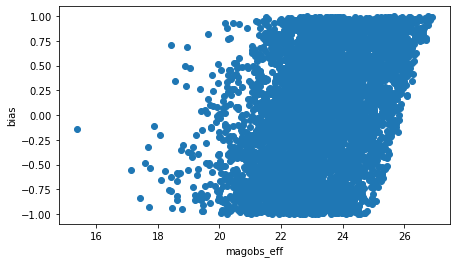

In [4]:
fig = newtarget.show_scatter("magobs_eff","bias")
ax = fig.axes[0]

ax.set_xlabel("magobs_eff")
ax.set_ylabel("bias")

## Dissecting what happened

### Inheriting Transient

This bit of code specifies that `NewTransient` has all the `Transient` attributes and methods, plus all what goes next. Any attribute or method explicitely writting in `NewTransient` overwrite these of `Transient` (see [python class doc](https://docs.python.org/3/tutorial/classes.html))

```python
class NewTransient( Transient ):
```

### The generic information

You can provide the kind of transient in `_KIND`. This is just for having a name, say a SNII or here a `SNnew`.

The ``sncosmo.Model`` source you want to use to generate spectrum of lightcurve from the transient parameters if given in `_TEMPLATE`.

The volumetric rate that is used to see how to draw the transient redshift distribution is given as `_RATE`.


```python
    _KIND = "SNnew" # 
    _TEMPLATE = "no_defined_yet" # sncosmo template 
    _RATE = 1 * 10**3 # 
```

### Most importantly the **model**

The `_MODEL` attribute specifies how the data are drawn. 

See the documentation below to understand how to construct on.


```python
    _MODEL = dict( # Draw variable from a very simple method (only needs size as param).
                   magabs = {"model":"my_defined_method"},

                   # draw_redshift is defined for Transients
                   redshift = {"param":{"zmax":0.2},  "as":"z"}, # you can change the stored variable name.

                   # use a func drawing variables directly (e.g. numpy.random. )
                   noise = {"model": np.random.normal, 
                            "param":{"loc":0, "scale":0.5}},

                   # use one of the few pre-defined method e.g., magabs_to_magobs 
                    magobs = {"model": "magabs_to_magobs", 
                                "input":["z","magabs"]}, # "magabs_to_magobs has 2 mandatory inputs"

                    bias = {"model":np.random.uniform, 
                            "param":{"low":-1, "high":+1}},

                    # Create a complexe method that needs input.
                    magobs_eff = {"model": "my_method_needs_input", 
                                    "input":["magobs","bias"]},# "my_method_needs_input has 2 mandatory inputs"
                 )

```

### additional methods

The two additional methods are here used for as function for the `_MODEL`, `my_defined_method` (for `magabs`) and `my_method_needs_input` for `magobs_eff`.

**Remark** that ``magabs_to_magobs`` is a method already defined in `Transient`.

```python
    def my_defined_method(self, size=None, boundaries=[-14,-18]):
        """ """
        return np.random.uniform(*boundaries, size=size)

    # remark here, no size, it will be that of p1 and noise
    def my_method_needs_input(self, magobs, bias):
        """ returns ``scale*(a*coef + noise)``"""
        return magobs+bias
```

***
## Build a transient model

### Concept
To generate ``data``, the code reads **model** line-by-line and follows the instructions it contains. 

In this SNeIa example, **model** contains 8 entries. So the generated ``data`` will contains at least 8 columns (see the *as* option).

#### *model*, *param*, *as*, *input*

A **model** entry accepts 4 keywords:
  1. *model*: (name of) the function used to draw the sample, e.g. np.random.uniform ;
  2. *param*: options that enter the function as kwargs ;
  3. *as*: (list of) name(s) of the column on the resulting ``data`` ;
  4. *input*: list of already drawn entry used as argument for the *model* function (see e.g. ``magobs``)

#### the *input* option making **model**  a "DAG"
The *input* option enables you to generate self-consistent parameters. 

For instance, the absolute magnitude of a SNeIa depends on its stretch and color (following the ``alpha*x_1 - beta*c `` Tripp's relation). Hence, once the ``x_1``and ``c`` (independent) variables have been drawn, the SNeIa absolute magnitude (``magabs``) can be obtained using as input the already drawn ``x_1`` and ``c`` parameters. Same goes for the observed magnitude, it only dependents on the absolute magnitude ``magabs`` and the redshift ``z``. 

The (potentially complex) connections between the variables enabled by the *input* corresponds to the creation a [Directed acyclic graph](https://en.wikipedia.org/wiki/Directed_acyclic_graph).
You can complexify as you which your **model** creating as many variables and intermediate variables as you want.

#### the *model* option, where to define the function

The *model* option is the function that will be used to generate the dataset. In principle, it should should accept ``size`` as parameters and return N=size values.

In your **model**, the *model* option can be a function or a string. 
 - a function will be used as such
 - a string will be converted in function, it typically means you input a method of the class ; though more advanced tools exist, see "Build a new Model" documentation.
 
### Applied to NewTransient


In the ``NewTransient`` example, 

  1. the first draw parameters will be ``magabs`` and will be drawn using the ``my_defined_method()`` function. This one is a method of ``NewTransient``.
```python
                   # Draw variable from a very simple method (only needs size as param).
                   magabs = {"model":"my_defined_method"},
```

  2. the redshift is a special parameter drawn following the volumetric rate you defined above. Here we say we want to go up to zmax is 0.2 (`"param":{"zmax":0.2}`, zmax is an option of `self.draw_redshift()`. In addition, we want the redshift to be store as `z` in the dataframe, not "redshift".

```python
                   # draw_redshift is defined for Transients
                   redshift = {"param":{"zmax":0.2},  "as":"z"}, # you can change the stored variable name.

```

  3. we want noise, we simply want to use the [numpy.random.normal](https://numpy.org/doc/stable/reference/random/generated/numpy.random.normal.html) function to draw it. it will be centered on 0 with a sigma (scale) of 0.5 
```python
                   # use a func drawing variables directly (e.g. numpy.random. )
                   noise = {"model": np.random.normal, 
                            "param":{"loc":0, "scale":0.5}},
```
  4. generate the observed magnitude given the redshift (**z**) and the absolute magnitude (**magabs**) you have drawn in step 2 and 1, respectively. The `magabs_to_magobs` method is already defined in `Transient` so no need to re-defined it in `NewTransient`. The *input* option specifies that it is the **z** and **magabs** drawn before that should be used.
   
```python
                   # use one of the few pre-defined method e.g., magabs_to_magobs 
                    magobs = {"model": "magabs_to_magobs", 
                                "input":["z","magabs"]}, # "magabs_to_magobs has 2 mandatory inputs"

```

  5. just create a new random variable, called **bias** draw using the numpy function.
```python
                    bias = {"model":np.random.uniform, 
                            "param":{"low":-1, "high":+1}},
```

  6. The final parameters `magobs_eff` is obtained using the method `my_method_needs_input` and takes as input the already drawn `magobs` and `bias`.
```python
                    # Create a complexe method that needs input.
                    magobs_eff = {"model": "my_method_needs_input", 
                                    "input":["magobs","bias"]} # "my_method_needs_input has 2 mandatory inputs"


```

And here you go.